<br><br>

# Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados: 

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5. 
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [ ]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        print("Fatoração concluída. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

<br><br>

Tradicionalmente, para avaliarmos a performance de algoritmos de machine learning, fazemos a divisão dos dados em treino/teste; os dados de teste são utilizados no modelo final, apenas para validar que o mesmo não está sofrendo overfitting e está generalizando bem.

No contexto dos filtros colaborativos, tal divisão dos dados não fará sentido: os métodos discutidos (de filtragem colaborativa) usam as informações de interação dos usuários com itens para "preencher os valores faltantes" da matriz de interação. Esse preenchimento é justamente a recomendação!

<br>

No entanto, podemos aplicar uma __metodologia que "simula" dados de treino/teste.__ 

Essencialmente, essa metodologia consiste de criar uma base de treino em que retiramos algumas interações dos usuários. Dessa forma, os modelos irão aprender os padrões dos dados sem terem acesso a toda informação.

Nos dados de teste, usaremos essas interações retiradas em treino para avaliar os resultados.

<br>

__Considere o exemplo:__

Vamos carregar, novamente, o dataset que usamos ao longo do módulo:

In [ ]:
def getDF():
    dic__ = {"User_1":[np.nan, np.nan, np.nan, 1, 7, 2, 3, 8],
         "User_2":[9,10,2,2,6,5,3,8],
         "User_3":[4, 7, 9, 6,6,10,10,2],
         "User_4":[np.nan, 7, 9, 5, 5, 10, 9, 1],
         "User_5":[7.0,6.0,3.0,8.0,3,4.0,3.0, 2],
         "User_6":[np.nan, np.nan, 9, 9,6,8,9,np.nan],
         "User_7":[3,5,4,4,3,3,9,np.nan],
         "User_8":[10,10,10,10,2,2,2,2],
         "User_9":[9,9,np.nan,8,3,3,1,np.nan],
         "User_10":[9,8,10,9,3,4,2,1],
         "User_11":[4,4,3,3,9,9,8,10],
         "User_12":[2,2,4,1,8,10,10,9],
         "User_13":[1,4,1,3,7,10,7,8],
         "User_14":[3,3,2,1,1,10, np.nan,10],
         "User_15":[9,9,8,10,4,2,np.nan,1]
        }
    df = pd.DataFrame(dic__).T
    df.columns = ['Filme_'+str(int(i+1)) for i in range(8)]
    return df

In [ ]:
df = getDF()
df

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,NaN,NaN,NaN,1.0,7.0,2.0,3.0,8.0
User_2,9.0,10.0,2.0,2.0,6.0,5.0,3.0,8.0
User_3,4.0,7.0,9.0,6.0,6.0,10.0,10.0,2.0
User_4,NaN,7.0,9.0,5.0,5.0,10.0,9.0,1.0
User_5,7.0,6.0,3.0,8.0,3.0,4.0,3.0,2.0
User_6,NaN,NaN,9.0,9.0,6.0,8.0,9.0,NaN
User_7,3.0,5.0,4.0,4.0,3.0,3.0,9.0,NaN
User_8,10.0,10.0,10.0,10.0,2.0,2.0,2.0,2.0
User_9,9.0,9.0,NaN,8.0,3.0,3.0,1.0,NaN
User_10,9.0,8.0,10.0,9.0,3.0,4.0,2.0,1.0


<br>

Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

<br>

In [ ]:
ratings = df.fillna(0).values
ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

<br>

Na sequência, apresentamos a função que faz a divisão dos dados em treino e teste.

<br>

In [ ]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [ ]:
train, test = train_test_split(ratings, qtd = 2)

<br>

__Vamos comparar os dados de treino e teste com os dados originais:__
    
<br>

In [ ]:
#matriz de interação - original;

ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [ ]:
#dados de treino;
#observe que, para cada usuário (ou seja, para cada linha) 3 notas foram retiradas!! 
#ou seja, foram substituida por 0.

train

array([[ 0.,  0.,  0.,  0.,  7.,  2.,  0.,  8.],
       [ 0., 10.,  2.,  0.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  0.,  6.,  6.,  0., 10.,  2.],
       [ 0.,  7.,  0.,  0.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  0.,  0.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  0.,  0.,  0.],
       [ 3.,  5.,  0.,  4.,  3.,  3.,  0.,  0.],
       [10., 10., 10., 10.,  0.,  2.,  2.,  0.],
       [ 9.,  0.,  0.,  8.,  0.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  0.,  3.,  4.,  0.,  1.],
       [ 4.,  4.,  3.,  0.,  9.,  9.,  8.,  0.],
       [ 2.,  2.,  4.,  1.,  0., 10., 10.,  0.],
       [ 1.,  4.,  1.,  0.,  7., 10.,  7.,  0.],
       [ 3.,  3.,  2.,  0.,  0., 10.,  0., 10.],
       [ 9.,  0.,  0., 10.,  4.,  2.,  0.,  1.]])

In [ ]:
#dados de teste;
#observe que exatamente as notas que foram retiradas de treino são colocadas nessa matriz de teste!!

test

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  3.,  0.],
       [ 9.,  0.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  9.,  5.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  8.,  9.,  0.],
       [ 0.,  0.,  4.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.],
       [ 0.,  9.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  9.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  9.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  9.,  8.,  0.,  0.,  0.,  0.,  0.]])

<br>

Na prática, usaremos os dados de treino para treinar e escolher os modelos.

Neste caso, podemos, inclusive, fazer a divisão em treino/validação/teste:
    


In [ ]:
train, val = train_test_split(train, qtd = 2)

In [ ]:
train

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0., 10.,  0.,  0.,  6.,  5.,  0.,  8.],
       [ 0.,  7.,  0.,  6.,  6.,  0.,  0.,  2.],
       [ 0.,  7.,  0.,  0.,  0., 10.,  0.,  1.],
       [ 7.,  6.,  0.,  0.,  0.,  4.,  3.,  0.],
       [ 0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  4.,  3.,  0.,  0.,  0.],
       [10., 10.,  0.,  0.,  0.,  2.,  2.,  0.],
       [ 0.,  0.,  0.,  8.,  0.,  3.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  3.,  4.,  0.,  1.],
       [ 4.,  4.,  3.,  0.,  0.,  9.,  0.,  0.],
       [ 2.,  2.,  0.,  1.,  0.,  0., 10.,  0.],
       [ 1.,  0.,  1.,  0.,  7.,  0.,  7.,  0.],
       [ 3.,  3.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  4.,  2.,  0.,  1.]])

In [ ]:
val

array([[ 0.,  0.,  0.,  0.,  7.,  2.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  3.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  5.,  0.,  9.,  0.],
       [ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  9.,  0.,  6.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 0.,  0., 10., 10.,  0.,  0.,  0.,  0.],
       [ 9.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 9.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  9.,  0.,  8.,  0.],
       [ 0.,  0.,  4.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 10.,  0., 10.],
       [ 9.,  0.,  0., 10.,  0.,  0.,  0.,  0.]])

In [ ]:
test

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  3.,  0.],
       [ 9.,  0.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  9.,  5.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  8.,  9.,  0.],
       [ 0.,  0.,  4.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.],
       [ 0.,  9.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  9.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  9.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  9.,  8.,  0.,  0.,  0.,  0.,  0.]])

<br>

Observe que, se "juntamos" os dados das 3 tabelas acima, retornamos com os dados originais:
    
<br>

In [ ]:
train + val + test

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [ ]:
(train + val + test) == ratings

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

<br>

Ou seja, com a metodologia acima, temos uma "divisão" dos dados em treino/validação/teste!


Desta forma, podemos usar a metologia padrão de avaliação dos modelos:
    
    - Fitamos os modelos nos dados de treino;
    
    - Avaliamos os modelos nos dados de validação;
    
    - Escolhemos o modelo final, a partir dos resultados de validação;
    
    - Avaliamos o modelo final nos dados de teste.
    
    
<br>


__Ponto de atenção:__

Ao calcularmos as métricas de performance, apenas os valores não nulos dos dados de validação/teste devem ser usados.

<br><br>

Vejamos um exemplo:

In [ ]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [ ]:
fat.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [ ]:
#predição usando apenas os dados de treino!!

pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,9.15,9.25,4.55,6.94,6.14,5.88,5.76,7.77
User_2,9.75,9.72,4.75,7.54,5.98,4.96,4.67,7.70
User_3,6.01,6.68,5.86,5.99,5.92,5.64,5.98,2.14
User_4,5.54,6.80,6.76,6.05,8.76,9.70,10.66,1.14
User_5,6.72,6.04,3.45,4.59,3.84,3.64,3.26,4.29
User_6,8.29,9.63,7.70,8.81,8.23,6.86,7.37,3.34
User_7,4.51,4.81,3.24,4.00,3.03,2.65,2.67,3.07
User_8,9.67,9.81,5.63,8.54,5.03,2.28,1.82,5.91
User_9,7.66,8.58,5.90,7.76,5.05,2.98,3.01,4.41
User_10,6.32,6.74,9.59,6.53,3.02,3.97,4.15,1.00


<br>

Veja que a matriz resultante __não é esparsa!__

Dessa forma, como sabemos, podemos utilizá-la para as recomendações.

Como __nosso objetivo no exercício é avaliar performance__, podemos __comparar__ os resultados dessa matriz resultante com os valores dos dados de validação!

In [ ]:
pd.DataFrame(val, columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0
User_2,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0
User_3,4.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
User_4,0.0,0.0,0.0,0.0,5.0,0.0,9.0,0.0
User_5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0
User_6,0.0,0.0,9.0,0.0,6.0,0.0,0.0,0.0
User_7,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
User_8,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0
User_9,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
User_10,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

### Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados). 

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

Bom, primeiramente carregamos a matriz dentro de um objeto o qual chamaremos de "R"

In [ ]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Após o carregamento da tabela, vêmos que há uma quantidade elevada de valores "NaN" então inicialmente, vamos substituir esses valores por zero. 

In [ ]:
rating = R.fillna(0).values
rating

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

Em seguida vamos fazer uma função que splita os dados de ratings (ou notas que foram estabelecidas aos filmes) em subdatasets de treino e teste. Também iremos fazer uma dataset de validação.

In [ ]:
def train_test_split(rating, qtd):
    test = np.zeros(rating.shape)
    train = rating.copy()
    for user in range(rating.shape[0]):
        test_rating = np.random.choice(rating[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_rating] = 0.
        test[user, test_rating] = rating[user, test_rating]
        
    return train, test

In [ ]:
train, test = train_test_split(rating, qtd = 2)

In [ ]:
training, val = train_test_split(train, qtd = 2)

In [ ]:
training

array([[5., 3., 4., ..., 1., 4., 0.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [ ]:
val

array([[0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
(training + val + test) == rating

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Após essa divisão, vamos testar modelos de fatorização nos dados de treinamento através da classe que nos foi dada no início do exercício e checar o quão este modelo se assemelha aos dados reais.

In [ ]:
facto = MatrixFactorization(dataframe = pd.DataFrame(training, columns = R.columns, index = R.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2) #Criando a fatorização nos dados de treino


In [ ]:
facto.fit() #Fitando os dados 

Fatoração concluída. Tempo aproximado: 38 minuto(s).


In [ ]:
pd.DataFrame(facto.predict(), columns = R.columns, index = R.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,3.86,2.89,3.21,3.62,2.92,4.07,4.02,3.70,4.30,4.27,...,3.73,3.29,3.05,2.64,3.86,3.41,2.99,1.78,3.80,2.55
User_1,3.88,2.76,2.53,3.13,3.01,4.26,4.52,3.63,4.48,3.84,...,3.37,3.58,3.29,2.41,4.45,3.42,2.07,2.03,3.67,2.32
User_2,3.51,2.45,2.67,2.93,2.66,3.91,3.41,3.43,4.14,4.05,...,3.31,2.92,2.62,2.41,3.63,2.70,2.48,1.54,3.19,2.38
User_3,4.13,3.43,3.73,4.30,3.28,3.83,4.35,4.09,4.24,4.19,...,4.10,3.47,3.45,3.03,3.63,4.01,3.71,2.04,4.44,2.85
User_4,4.31,3.38,3.14,3.67,3.56,4.14,4.27,4.23,4.43,4.05,...,4.02,3.63,3.62,3.01,3.88,3.60,3.32,2.26,4.28,2.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,2.96,2.75,2.68,3.45,2.55,2.24,3.68,3.10,2.92,2.40,...,2.81,2.61,2.84,2.36,2.55,3.47,2.58,1.73,3.61,2.13
User_363,4.47,3.76,3.83,4.42,3.80,3.80,4.24,4.79,4.65,4.34,...,4.36,3.49,3.69,3.65,3.51,3.95,4.12,2.23,4.75,3.45
User_364,4.02,3.11,3.57,3.96,2.98,4.22,4.24,3.67,4.18,4.40,...,4.02,3.49,3.23,2.61,3.88,3.75,3.41,1.88,4.08,2.49
User_365,3.60,2.87,2.40,3.03,3.10,3.26,3.83,3.67,3.78,3.04,...,3.17,3.09,3.18,2.61,3.34,3.14,2.45,2.03,3.66,2.45


In [ ]:
pd.DataFrame(val, columns = R.columns, index = R.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
User_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
User_363,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


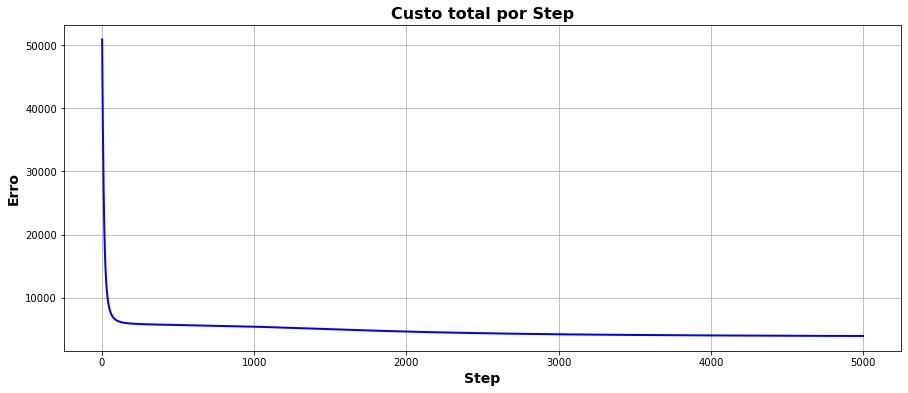

In [ ]:
facto.print_MSE_steps()

Podemos notar uma queda do MSE conforme aumentava-se os steps e também nota-se uma diferença entre os valores preditos pela fatoração e os valores inputados reais pelo usuário (ex: user 363 deu nota 2 para o filme 1 porém o modelo previu uma nota maior) para poder avaliar esse modelo vamos checar seu R².

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_true = rating, y_pred = facto.predict())

-6.053580872697793

O R² não indicou um erro muito alto, porém iremos avaliar outros modelos através de um loop variando o número de steps, alpha, beta e o de k para ver se podemos obter um resultado mais acurado.

In [ ]:
kl=MatrixFactorization(dataframe = pd.DataFrame(training, columns = R.columns, index = R.index), K=3, steps = 1000, 
                       alpha = 0.01, beta = 0.1)
kf=MatrixFactorization(dataframe = pd.DataFrame(training, columns= R.columns, index = R.index), K=4, steps = 2000,
                      alpha = 0.01, beta = 0.3)
kg=MatrixFactorization(dataframe = pd.DataFrame(training, columns= R.columns, index = R.index), K=5, steps = 4000,
                      alpha = 0.001, beta = 0.4)



In [ ]:
modelos = [kl, kf, kg, facto]
for modelo in modelos:
    modelo.fit()
    predicoes = modelo.predict()
    r2_teste = r2_score(y_true= rating, y_pred=predicoes)
    print(modelo, " | r2:", r2_teste)

Fatoração concluída. Tempo aproximado: 6 minuto(s).
<__main__.MatrixFactorization object at 0x00000030F5488730>  | r2: -7.024687041014286
Fatoração concluída. Tempo aproximado: 13 minuto(s).
<__main__.MatrixFactorization object at 0x00000030F5488580>  | r2: -5.8576555447154695
Fatoração concluída. Tempo aproximado: 30 minuto(s).
<__main__.MatrixFactorization object at 0x00000030F54883A0>  | r2: -5.4155282361972565
Fatoração concluída. Tempo aproximado: 35 minuto(s).
<__main__.MatrixFactorization object at 0x00000030F23168E0>  | r2: -5.877581438685205


Após a fatorização o modelo Kg foi o que obteve o melhor valor de R², logo podemos dizer que foi o melhor modelo de recomendação de filmes dentre os que avaliamos, então seria o mais adequado para ser posto em prática.